In [1]:
from ecnet.datasets import load_cp
from ecnet.tasks.feature_selection import select_rfr
from ecnet import ECNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
import torch
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
dataset = load_cp(as_dataset=True, backend='alvadesc')
print(dataset.desc_vals.shape, dataset.target_vals.shape)

torch.Size([43, 5305]) torch.Size([43, 1])


In [3]:
index_train, index_test = train_test_split([i for i in range(len(dataset))],
                                           test_size=0.2, random_state=42)
dataset_train = deepcopy(dataset)
dataset_train.set_index(index_train)
dataset_test = deepcopy(dataset)
dataset_test.set_index(index_test)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([34, 5305]) torch.Size([9, 5305])


In [4]:
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95,
                                n_estimators=100, n_jobs=4)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
desc_names = [dataset.desc_names[i] for i in desc_idx]
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(desc_names[:5], len(desc_names))
print(desc_imp[:5])
with open('_models/cp_desc.txt', 'w') as txt_file:
    txt_file.writelines([str(i) + '\n' for i in desc_idx])
txt_file.close()

torch.Size([34, 69]) torch.Size([9, 69])
['VE2sign_Dz(p)', 'GATS5s', 'VE2sign_Dz(m)', 'VE2sign_Dz(v)', 'VE2sign_Dz(e)'] 69
[0.05018058057638171, 0.04794530608431601, 0.04675385825711076, 0.042760348487451194, 0.041944185344894615]


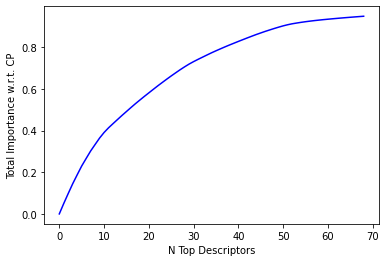

In [5]:
plt.clf()
x_vals = [i for i in range(len(desc_imp))]
y_vals = [0.0]
for idx in range(len(desc_imp) - 1):
    y_vals.append(sum(desc_imp[:idx + 1]))
plt.xlabel('N Top Descriptors')
plt.ylabel('Total Importance w.r.t. CP')
plt.plot(x_vals, y_vals, color='blue')
plt.show()

In [6]:
model = ECNet(dataset_train.desc_vals.shape[1], dataset_train.target_vals.shape[1],
              64, 1)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=100, epochs=500, random_state=24, lr=0.01, lr_decay=1e-8
)

Epoch: 0 | Train loss: 4093.21826171875 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 1154.4542236328125 | Valid loss: 2290.5068359375
Epoch: 20 | Train loss: 665.666259765625 | Valid loss: 1066.5096435546875
Epoch: 30 | Train loss: 497.65216064453125 | Valid loss: 1237.2618408203125
Epoch: 40 | Train loss: 452.1821594238281 | Valid loss: 1041.8057861328125
Epoch: 50 | Train loss: 432.5159912109375 | Valid loss: 1011.40185546875
Epoch: 60 | Train loss: 413.5530090332031 | Valid loss: 1029.6983642578125
Epoch: 70 | Train loss: 386.8307189941406 | Valid loss: 929.8781127929688
Epoch: 80 | Train loss: 357.30450439453125 | Valid loss: 881.0050659179688
Epoch: 90 | Train loss: 321.468994140625 | Valid loss: 820.1403198242188
Epoch: 100 | Train loss: 275.5029296875 | Valid loss: 720.5403442382812
Epoch: 110 | Train loss: 217.30979919433594 | Valid loss: 591.1009521484375
Epoch: 120 | Train loss: 147.24734497070312 | Valid loss: 441.8384094238281
Epoch: 130 | Train loss: 80.469787

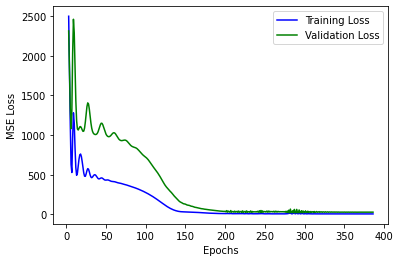

In [7]:
plt.clf()
train_loss = train_loss[3:]
valid_loss = valid_loss[3:]
epoch = [i for i in range(3, len(train_loss) + 3)]
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [8]:
y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals.numpy()
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals.numpy()

mae_train = median_absolute_error(y_hat_train, y_train)
mae_test = median_absolute_error(y_hat_test, y_test)
r2_train = r2_score(y_hat_train, y_train)
r2_test = r2_score(y_hat_test, y_test)
print(f'Training set: {mae_train} | {r2_train}')
print(f'Testing set: {mae_test} | {r2_test}')

Training set: 2.1148033142089844 | 0.9822329672773344
Testing set: 4.0024261474609375 | 0.9647756922334071


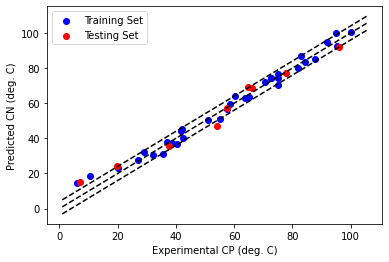

In [9]:
min_val = min(min(y_hat_train), min(y_train)) - 0.05 * max(max(y_hat_train), max(y_train))
max_val = max(max(y_hat_train), max(y_train)) + 0.05 * max(max(y_hat_train), max(y_train))
plt.clf()
plt.xlabel('Experimental CP (deg. C)')
plt.ylabel('Predicted CN (deg. C)')
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--')
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [10]:
model.save('_models/cp.pt')